# Mechanical Power
In this Notebook, we replicate the energy-based approach to quantifying the mechanical demands of overground, constant velocity and/or intermittent running patterns as presented by [Gray et al. (2020)][0] and [Lee and Farley (1998)][2] with `Python` code. The total work done ($W_{total}$) is determined from the **sum** of the four sub components: work done to accelerate the centre of mass horizontally ($W_{hor}$), vertically ($W_{vert}$), to overcome air resistance ($W_{air})$ and to swing the limbs ($W_{limbs}$)
$$W_{total} = \bigl|W_{hor}\bigl| + \bigl|2 * W_{vert}\bigl| + W_{air} + W_{limbs}$$

## Importing Data and Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

# disable warnings for division through zero
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## COM & Limb kinematics
The movement of the **centre of mass (COM)** is tightly coupled to running speed and can be imagined as a **bouncing ball**. Considering one step the COM is the *lowest during mid-support* and the *highest during mid-flight*. This vertical displacement ($ \Delta~h~in~m$) of the COM can roughly estimated using the following equation:

<center> 

$\Delta h = - 0.080 + 0.004 * v$

</center>

where $v$ has the unit $\frac {m}{s}$. The calculation is based on a **linear correlation between running speed and vertical COM displacement** ($r^2 = 0.444,~p = 0.034,~n = 90$). [Gray et al. (2020)][0] report a slightly modified version from the original equation above. This notebook will stick to the original calculation based on [Lee and Farley (1998)][2]. For more information the reader is referred to the description of figure 3 in the [Lee and Farley (1998)][2] article.

Furthermore the stride frequency ($f~in~Hz$) and the duty factor ($d~in~\%$, the duty factor is the percentage of the stride cycle in which a single limb is in the support phase) need to be calculated. For this purpose, two equations are proposed by [Gray et al. (2020)][0]:

<center> 

$f = 0.026 * v^2 - 0.111 * v + 1.398$

$d = 0.004 * v^2 - 0.061 * v + 0.50 $

</center>

Both equations originate from a previous publication from the same author [Gray et al. (2019)][1]. They report an **$R^2$ of 0.903 and 0.652** for f and d, respectively, in comparison between equation and measured data. For further information the reader is directed to the paper of [Gray et al. (2019)][1].

All three equations are implemented in the following section of code. For the sake of this demonstration a **new array containing speeds from 0 - 10** $\frac {m}{s}$ is created and used for the calculations. This enables us to gain a rough understanding on how $ \Delta~h$, $f$ and $d$ behave in different velocities.


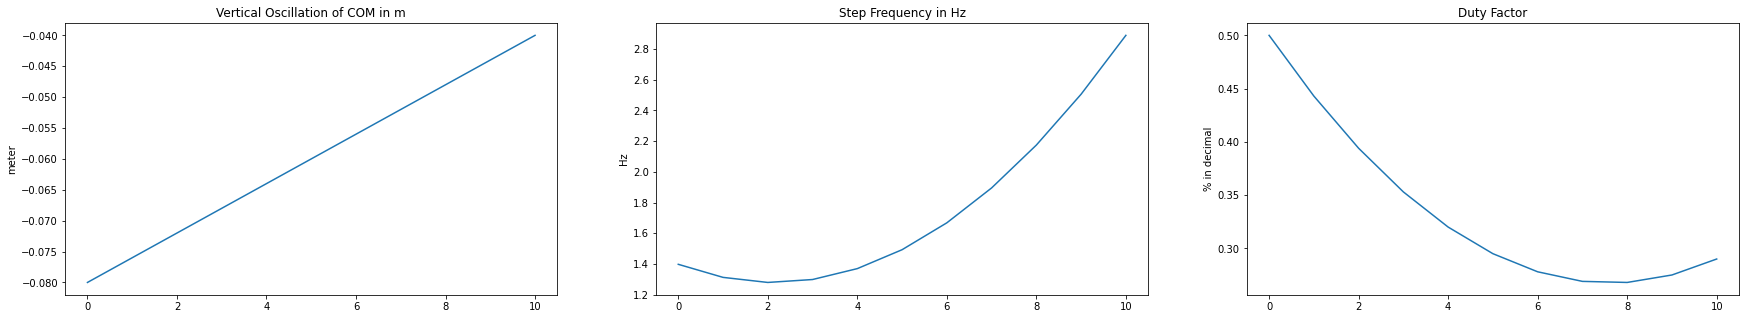

In [3]:
v_ex = np.arange(0,11,1)
dh =  -0.080 + 0.004 * v_ex  # different dh-equation than Gray et al: -0.080 vs - 0.008                                                   
f = 0.026 * v_ex**2 - 0.111 * v_ex + 1.398
d = 0.004 * v_ex**2 - 0.061 * v_ex + 0.5

fig = plt.figure(figsize=(30, 5))
plt.subplot(1,3,1)
plt.title('Vertical Oscillation of COM in m')
plt.ylabel("meter")
plt.plot(v_ex, dh)

plt.subplot(1,3,2)
plt.title('Step Frequency in Hz')
plt.ylabel('Hz')
plt.plot(v_ex, f)

plt.subplot(1,3,3)
plt.title('Duty Factor')
plt.ylabel('% in decimal')
plt.plot(v_ex, d)

The graph on the left shows the **linear relationship between the vertical oscillation of the COM and the running speed**. Higher running speed result in larger vertical oscillations of the COM. The stride frequency initially decreases up to about $2 \frac {m}{s}$, therefore the increases in running speed must be related to increased step length. Afterwards the stride frequency increases almost exponentially with increased running speed. Lastly, the duty factor decreases up to about $7.5 \frac {m}{s}$ and afterwards increases. 

The following lines of code display an interactive tool that allows the reader to manipulate the velocity ($v$ in $\frac {m}{s}$). Based on the manipulation the **vertical oscillation of the COM** is plotted against time over a duration of 5 seconds.

In [4]:
def oscillation_sim(v):
    dh = -0.080 + 0.004 * v
    f = 0.026 * v**2 - 0.111 * v + 1.398
    x = np.arange(0, 5, 0.00001)
    w = 2 * np.pi * f                           # calculating w to manipulate sinusfunction based on stride frequency                  
    fc = dh/2 * np.sin(w*x)
    print('Vertical Oscillation of COM [m]: ' + str(np.round(dh, 3)))
    print('Stride Frequency [Hz]: ' + str(np.round(f, 3)))
    fig = plt.figure(figsize=(30, 5))
    plt.plot(x,fc)
    plt.ylim(-0.04, 0.04)
    plt.xlabel('Time [s]')
    plt.ylabel('Vertical Oscillation CON [m]')
    return

widgets.interact(oscillation_sim, v = widgets.FloatSlider(value = 5, min = 1, max = 15, step = 0.1))

interactive(children=(FloatSlider(value=5.0, description='v', max=15.0, min=1.0), Output()), _dom_classes=('wi…

<function __main__.oscillation_sim(v)>

---

## External Work
The external work performed can be subdivided into the *horizontal work* needed to accelerate and decelerate the COM ($W_{hor}$), the *vertical work* needed to oscillate the COM ($W_{vert}$) and the work needed to overcome the *air resistance* ($W_{air}$). The overall external work is the sum of the three subcompartments:

<center> 

$W_{ext} = W_{hor} + W_{vert} + W_{air}$

</center> 

The calculation of each subdepartment is explained in the following.

### Calculating Horizontal Work
$W_{hor}$ is the change of horizontal kinetic energy ($k_{en}$) according to the [Work-Energy-Theorem][3]. Kinetic energy can be calculated using the following equation: 

<center> 

$k_{en} = \frac{1}{2} * m * v^2$

</center> 

Mass is simply a *scaling factor* and can therefore be removed if $k_{en}$ is expressed per kg. Consequently, as $W_{hor}$ is the change of horizontal $k_{en}$ the following equation can be used:

<center> 

$W_{hor} = \frac{1}{2} * ( v^2_n - v^2_{n+1})$

</center> 

$W_{hor}$ yields positive values for accelerations and negative values for decelerations. 

### Calculating Vertical Work

The **vertical work** performed depends on the **vertical oscillation of the COM and the stride frequency**. It is calculated using the following equation. Similar to the previous equations the scaling factor mass is removed.

<center>

$W_{vert} = 2 * g * \Delta h * f $

</center>

### Calculating Work to overcome Air Resistance

The *air resistance* is an external force ($F_{air}$) applied by the volume of air that meets and passes around the surface of a body. The force can be calculated using the following equation:

<center>

$F_{air} = \frac{1}{2} * p * A_p * S^2 * C_d$

</center>

Where during **calm conditions** $S = v$ and $p$ is the air density ($\frac {kg}{m^3}$), which can be calculated from the temperature ($T~in~°C$) and the pressure ($BP~in~mmHg$):

<center>

$p = \frac {273 * p_o * BP}{760 * T}$

</center>

Where $p_o = 1.293 \frac{kg}{m^3}$ is the air density at sea level and 273° Kelvin.

$A_p$ is the projected **frontal surface** area of a running human. It is approximately 26% of the total body surface area. $A_p$ ($m^2$) can be calculated using the following equation:

<center>

$A_p = 0.26 * (0.000949 * ht^{0.655} * M^{0.441})$

</center>

Where $ht$ is the runners standing height in centimeters and $M$ is the body mass in kg. Note that Gray et al. (2020) present a slightly **modified version** of this equation that requires the standing height in meters.

Taking the equations into consideration $W_{air}$ is proportional to the cube of the runners forward velocity (with $t$ as time in seconds):

<center>

$W_{air} = \frac {\frac{1}{2} * p * A_p * v^3 * C_d * t}{M}$

</center>

The following section of codes calculates the **mechanical demand for the three subcomparments** for the steady-state velocities from 0 - 10 $\frac{m}{s}$ used in the previous calculations. Note that the horizontal mechanical demand is equal to zero due to the absence of a change in velocity. The produced plots can be compared to **figure 2a and 2b from Gray et al. 2020**.

(0.0, 11.0)

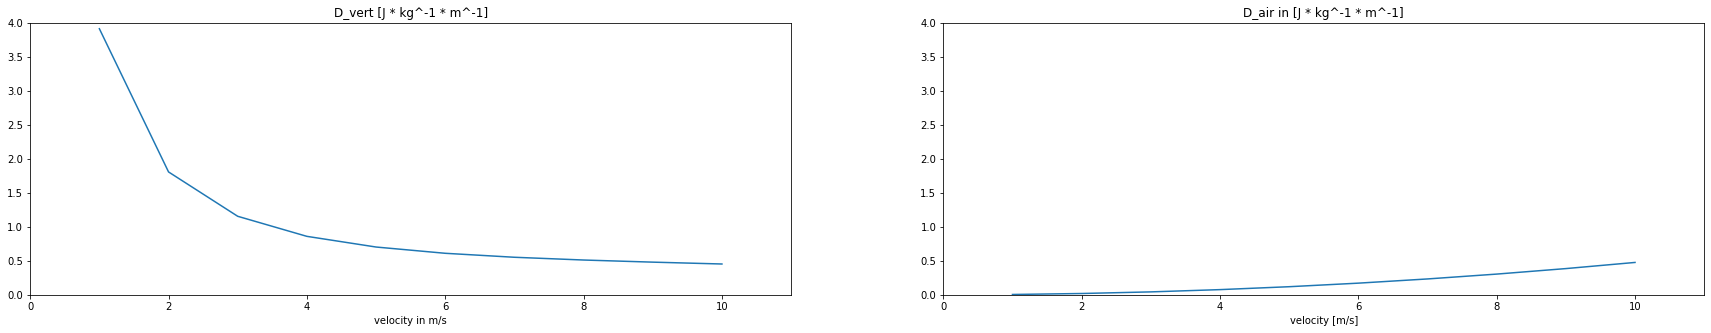

In [5]:
# Calculating Horizontal Work
#W_horz = np.cumsum(0.5 * (np.gradient(v_ex**2)))
W_horz = np.zeros(len(d))

# Calculating Vertical Work
#W_vert = abs(np.cumsum(2 * 9.81 * dh * f))
t_i = 10
W_vert =  (abs(2 * 9.81 * dh * f * t_i)) * 2    # multiplied by 2 according to eq. 14

# Calculating Air Work
## defining constants
p_0 = 1.293                                     # air density at sea level and 273 Kelvin
BP = 760                                        # atmospheric pressure at sea level
T = 23                                          # Temperature in °C
ht = 189                                        # Runners standing height in cm
M = 89.3                                        # Runners body mass in kg     
C_d = 1                                         # C_d = 1 in this approach, no further explanations           
t_i = 10                                        # time interval in s 

## Calculating air density and frontal area
p = (273 * p_0 * BP) / (760 * T)                    # calculating air density
A_p = 0.26 * (0.000949 * ht**0.655 * M**0.441)      # calculating runners frontal surface area -> they may give the wrong formula in the paper 0.000949 instead of 94.9

## Calculating Air Work
#W_air =np.cumsum(0.5 * p * A_p * v_ex**3 * C_d * t_i / M)
W_air =  ((0.5 * p * A_p * v_ex**3 * C_d * t_i) / M)  

# Converting Work to Power
P_air = W_air / t_i
P_vert = W_vert / t_i
P_horz = W_horz / t_i

# Converting Power to mechanical demand
D_air = P_air / v_ex
D_vert = P_vert / v_ex
D_horz = P_horz / v_ex

fig = plt.figure(figsize=(30, 5))
plt.subplot(1,2,1)
plt.plot(v_ex, D_vert)
plt.title("D_vert [J * kg^-1 * m^-1]")
plt.xlabel("velocity in m/s")
plt.ylim(0,4)
plt.xlim(0,11)

plt.subplot(1,2,2)
plt.plot(v_ex, D_air)
plt.title("D_air in [J * kg^-1 * m^-1]")
plt.xlabel("velocity [m/s]")
plt.ylim(0,4)
plt.xlim(0,11)

## Internal Work

The internal work is characterised by the movement of the **bodies' segments in relation to bodies' COM**. The following equation may be used to calculate the mechanical work done to swing the limbs per unit of distance traveled ($D_{limbs}~in~\frac{J}{kg * m}$). Also the equation to calculate the performed $W_{limbs}$ is provided below:

<center>

$D_{limbs} = q * v * f * (1+(\frac{d}{1-d})^2) $

$W_{limbs} = q * v^2 * f * (1+(\frac{d}{1-d})^2) * t_i$ 

</center>

where $q = 0.1$ is a constant factor that reflects the **inertial properties of the limbs and mass partitioning between the limbs and the rest of the body**. Note that Gray et al. (2020) use the square of the velocity instead of the velocity itself. In order to output $D_{limbs}~in~\frac{J}{kg * m}$ this notebook uses the velocity itself according to the original [literature (equation 5)][4]. Consequently the exponent for the velocity in the equation of $W_{limbs}$ is similarly decreased by 1 in comparison to the paper from Gray et al. (2020).

The following code visualizes $D_{limbs}$ and can be compared to **figure 2c of Gray et al. (2020)**. Interestingly, despite some changes in our calculations our script yields similar graphics. Also $D_{total}$ and $W_{limbs}$ are calculated.

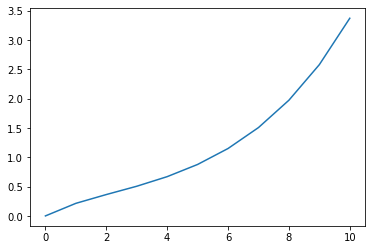

In [6]:
q = 0.1
D_limbs = q * v_ex * f * (1+(d/(1-d))**2)                               # changed exponent from ^2 to ^1

plt.plot(v_ex, D_limbs)
plt.show()

W_limbs = (q * v_ex**2 * f * (1 + (d/(1-d))**2 ) * t_i)                 # exponent changed from ^3 to ^2
D_total = (W_vert + W_air + W_limbs + W_horz) / (t_i * v_ex)

The following plot displays the proportion of the **mechanical demand of the limbs**, the vertical **oscillation of the COM** and the **air resistance as a percentage** of the overall mechanical demand and the overall mechanical for each velocity during in the absence of an acceleration. This example still displays constant speed running, therefore $W_{hor}$ is **zero** and consequently not included in the following graphic. It can be compared to **figure 3 and 4** of the paper from Gray et al. (2020).

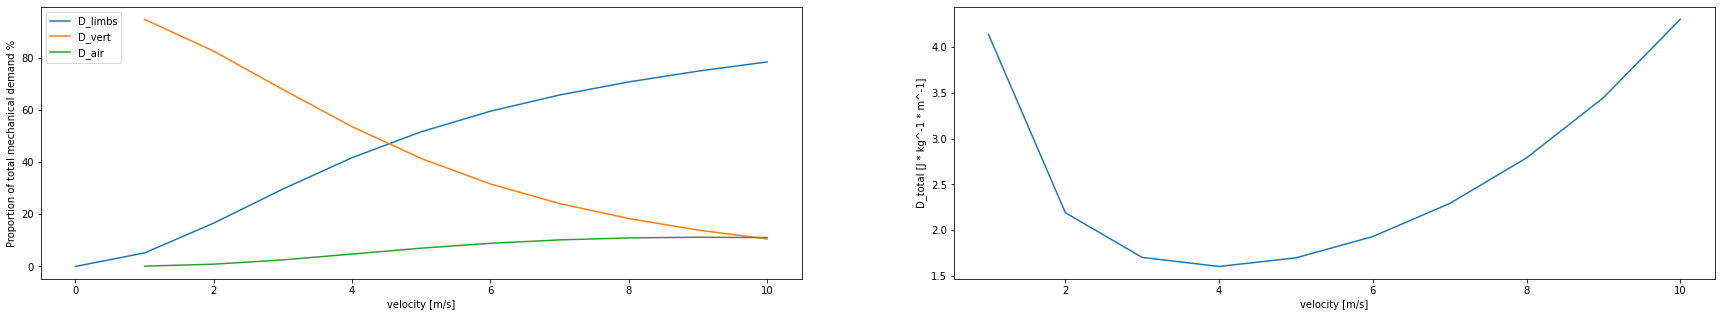

In [7]:
fig = plt.figure(figsize=(30, 5))
plt.subplot(1,2,1)
plt.xlabel('velocity [m/s]')
plt.ylabel('Proportion of total mechanical demand %')
plt.plot(v_ex, D_limbs/D_total*100, label='D_limbs')
plt.plot(v_ex, D_vert/D_total*100, label='D_vert')
plt.plot(v_ex, D_air/D_total*100, label='D_air')
plt.legend()

plt.subplot(1,2,2)
plt.ylabel('D_total [J * kg^-1 * m^-1]')
plt.xlabel('velocity [m/s]')
plt.plot(D_total)

---
# Calculating Total Work during Intermittent Running Bouts


In the following a **function** is developed to model the mechanical work, power and demand of **intermittend running bouts**. So far work has only been calculated for **single data points and constant velocities**. In order to calculate the overall performed work the **cumulative sum needs to be calculated**. Due to the change of velocities $W_{hor}$ is now included in the calculations. The following lines of code model a 6-second-long all out sprint performance, with all constants set according the exemplarily modelled sprint by Gray et al. (2020). The figure below can be compared to **figure 7** in Gray et al. (2020). 

# (Except p_vert?!?!)

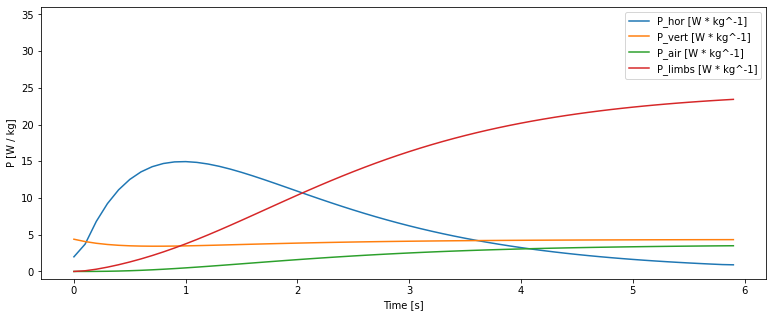

In [8]:
zeit_sprint = np.arange(0,6,0.1)
sprint = 9.16 * (1 - np.exp(-zeit_sprint/1.4))

def mechanical_power(v, s_f):                                                    # v in m/s and s_f in Hz
    
    t_i = 1 / s_f                                                                # converting sampling frequency into length of period

    # Oscillation COM, stride frequency and duty factor
    dh =  -0.080 + 0.004 * v                                                     # report different equation than in cited paper, -0.080 vs - 0.008
    f = 0.026 * v**2 - 0.111 * v + 1.398
    d = 0.004 * v**2 - 0.061 * v + 0.5

    # Calculating horizontal and vertical work
    try:
        W_horz = (abs(0.5 * (np.gradient(v**2))))
        W_horz_cum = np.cumsum(abs(0.5 * (np.gradient(v**2))))
    except: 
        W_horz = np.zeros(1)
        W_horz_cum = np.zeros(1)
    
    W_vert = abs(((2 * 9.81 * dh * f * t_i)) * 2)          # values for vertical do not fit to figure 7

    
    W_vert_cum = np.cumsum(abs(((2 * 9.81 * dh * f * t_i)) * 2)) 
   

    # Calculating Air Work
    ## defining constants
    p_0 = 1.293                                           # air density at sea level and 273 Kelvin
    BP = 760                                              # atmospheric pressure at sea level
    T = 23                                                # Temperature in °C
    ht = 189                                              # Runners standing height in cm
    M = 89.3                                              # Runners body mass in kg     
    C_d = 1                                               # C_d = 1 in this approach, no further explanations           
                                   

    ## Calculating air density and frontal area
    p = (273 * p_0 * BP) / (760 * T)                    # calculating air density
    A_p = 0.26 * (0.000949 * ht**0.655 * M**0.441)      # calculating runners frontal surface area -> they may give the wrong formula in the paper 0.000949 instead of 94.9


    ## Calculating Air Work
    W_air =  ((0.5 * p * A_p * v**3 * C_d * t_i) / M)
    W_air_cum = np.cumsum((0.5 * p * A_p * v**3 * C_d * t_i) / M)

    # Calculating internal Work
    W_limbs = (q * v**2 * f * (1 + (d/(1-d))**2 ) * t_i)   
    W_limbs_cum = np.cumsum(q * v**2 * f * (1 + (d/(1-d))**2 ) * t_i)  

    # Calculating Total Work
    W_total = W_vert + W_horz + W_limbs + W_air
    W_total_cum = W_vert_cum + W_horz_cum + W_limbs_cum + W_air_cum


    #Calculating Power for segments and total
    P_vert = W_vert / t_i 
    P_horz = W_horz / t_i
    P_limbs = W_limbs / t_i
    P_air = W_air / t_i
    P_total = W_total / t_i

    # Calculating mechanical demand for segments and total
    below_one = (v > 1)
    D_vert = P_vert / v * below_one
    D_horz = P_horz / v * below_one
    D_limbs = P_limbs / v * below_one
    D_air = P_air / v * below_one
    D_total = P_total / v * below_one
    

    W = np.array([W_vert_cum, W_horz_cum, W_limbs_cum, W_air_cum, W_total_cum])
    P = np.array([P_vert, P_horz, P_limbs, P_air, P_total])     
    D = np.array([D_vert, D_horz, D_limbs, D_air, D_total])

    return W, P, D

W, P, D = mechanical_power(sprint, 10)

fig = plt.figure(figsize=(13, 5))
plt.ylabel('P [W / kg]')
plt.xlabel('Time [s]')
plt.ylim(-1, 36)
plt.plot(zeit_sprint, P[1], label="P_hor [W * kg^-1]")
plt.plot(zeit_sprint, P[0], label="P_vert [W * kg^-1]")
plt.plot(zeit_sprint, P[3], label="P_air [W * kg^-1]")
plt.plot(zeit_sprint, P[2], label="P_limbs [W * kg^-1]")
plt.legend()

The function can also be used to **import the velocity measured from GPS**. The code below projects an exemplary dataset with visualisations. Velocities below 1 $\frac{m}{s}$ are problematic for the calculation of the mechanical demand are were consequently removed for that part of the calculation.

Beware that the authors explicitly state that the model may **not** be applied to entire match data sets. Furthermore, the authors add multiple limitations of their model that are beyond the scope of this implementation. **For more information the reader is referred to the original paper.**

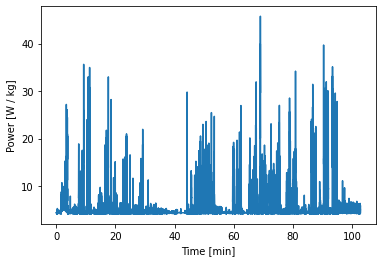

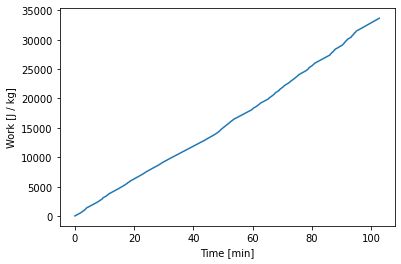

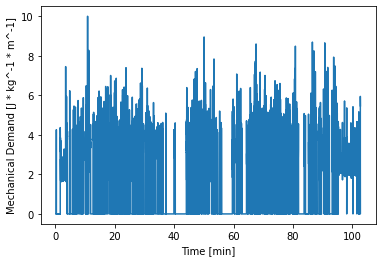

In [9]:
df = pd.read_csv('20200129_185931_1_Jessica_challenor_samples.csv')
v_data = np.array(df['Geschwindigkeit [km/h]']/3.6) 
time = np.arange(0, len(v_data), 1) / 10 / 60 

W, P, D = mechanical_power(v_data, 10)

plt.plot(time, P[4])
plt.ylabel('Power [W / kg]')
plt.xlabel('Time [min]')
plt.show()
plt.ylabel('Work [J / kg]')
plt.xlabel('Time [min]')
plt.plot(time, W[4])
plt.show()
plt.ylabel('Mechanical Demand [J * kg^-1 * m^-1]')
plt.xlabel('Time [min]')
plt.plot(time, D[4])

---
# Interactive Tool

Lastly an interactive tool is created. The sliders may be manipulated to change the velocity (steady-state-conditions) and sampling frequency. The function outputs three arrays with the following content:

1. Array: $W_{vert},~W_{horz},~W_{limbs},~W_{air}~and~W_{total}$
2. Array: $P_{vert},~P_{horz},~P_{limbs},~P_{air}~and~P_{total}$
3. Array: $D_{vert},~D_{horz},~D_{limbs},~D_{air}~and~D_{total}$

In [10]:

widgets.interact(mechanical_power, v = widgets.FloatSlider(value = 5, min = 1, max = 15, step = 0.1), s_f = widgets.FloatSlider(value = 10, min = 1, max = 20, step = 1))

interactive(children=(FloatSlider(value=5.0, description='v', max=15.0, min=1.0), FloatSlider(value=10.0, desc…

<function __main__.mechanical_power(v, s_f)>

## References

[0]: https://doi.org/10.1080/14763141.2020.1795238 

Gray, A., Andrews, M., Waldron, M., & Jenkins, D. (2020). A model for calculating the mechanical demands of overground running. Sports Biomechanics, 1-22.

[1]: https://journals.lww.com/nsca-jscr/Abstract/2021/09000/Predicting_Temporal_Gait_Kinematics_From_Running.2.aspx

Gray, A., Price, M., & Jenkins, D. (2021). Predicting temporal gait kinematics from running velocity. The Journal of Strength & Conditioning Research, 35(9), 2379-2382.

[2]: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.41.9689&rep=rep1&type=pdf

Lee, C. R., & Farley, C. T. (1998). Determinants of the center of mass trajectory in human walking and running. The Journal of experimental biology, 201(21), 2935-2944.

[3]: https://openstax.org/books/university-physics-volume-1/pages/7-3-work-energy-theorem

Ling, S. J., Sanny, J., & Moebs, W. (2016). University Physics, Volume 2 (OpenStax).

[4]: https://www.sciencedirect.com/science/article/abs/pii/S0021929098000384?via%3Dihub

Minetti, A. E. (1998). A model equation for the prediction of mechanical internal work of terrestrial locomotion. Journal of biomechanics, 31(5), 463-468.